In [1]:
import os

# os.environ["PYSYN_CDBS"] = "/home/ruizhew/POSEIDON/inputs/stellar_grids/"
# os.environ["POSEIDON_input_data"] = "/home/ruizhew/POSEIDON/inputs/"
from __future__ import absolute_import, unicode_literals, print_function
from POSEIDON.high_res import *
from POSEIDON.utility import read_high_res_data_deprecate
import numpy as np
from scipy import constants
from numba import jit
from POSEIDON.core import (
    create_star,
    create_planet,
    define_model,
    make_atmosphere,
    read_opacities,
    wl_grid_constant_R,
    wl_grid_line_by_line,
    compute_spectrum,
)
from POSEIDON.constants import R_Sun
from POSEIDON.constants import R_J, M_J
import numpy as np

/home/rwang/miniconda3/envs/poseidon/lib/python3.9/site-packages/POSEIDON/absorption.py:1466: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def store_Rayleigh_eta_LBL(wl_model, chemical_species):


In [2]:
from POSEIDON.core import define_model, wl_grid_constant_R

R_s = 1.21 * R_Sun  # Stellar radius (m)
T_s = 5605.0  # Stellar effective temperature (K)
Met_s = -0.04  # Stellar metallicity [log10(Fe/H_star / Fe/H_solar)]
log_g_s = 4.56  # Stellar log surface gravity (log10(cm/s^2) by convention)
# ***** Define planet properties *****#

planet_name = "WASP-77Ab"  # Planet name used for plots, output files etc.

R_p = 1.21 * R_J  # Planetary radius (m)
M_p = 1.76 * M_J  # Mass of planet (kg)
g_p = 4.3712  # Gravitational field of planet (m/s^2)
T_eq = 1043.8  # Equilibrium temperature (K)

# Create the planet object
planet = create_planet(planet_name, R_p, mass=M_p, gravity=g_p, T_eq=T_eq)

# If distance not specified, use fiducial value
if planet["system_distance"] is None:
    planet["system_distance"] = 1  # This value only used for flux ratios, so it cancels
d = planet["system_distance"]

# %%
from POSEIDON.core import define_model, wl_grid_constant_R
from POSEIDON.utility import read_high_res_data_deprecate

# ***** Define model *****#

model_name = "H2O, CO, CH4"  # Model name used for plots, output files etc.

bulk_species = ["H2", "He"]  # H2 + He comprises the bulk atmosphere
param_species = ["H2O", "CO"]  # H2O, CO as in Brogi & Line

high_res_params = ["K_p", "V_sys", "log_alpha"]

model = define_model(
    model_name,
    bulk_species,
    param_species,
    PT_profile="Madhu",
    high_res_params=high_res_params,
    reference_parameter="None",
)

# Check the free parameters defining this model
print("Free parameters: " + str(model["param_names"]))

# ***** Wavelength grid *****#

wl_min = 1.3  # Minimum wavelength (um)
wl_max = 2.6  # Maximum wavelength (um)
R = 250000  # Spectral resolution of grid
wl = wl_grid_constant_R(wl_min, wl_max, R)

opacity_treatment = "opacity_sampling"

# Define fine temperature grid (K)
T_fine_min = 400  # 400 K lower limit suffices for a typical hot Jupiter
T_fine_max = 4000  # 2000 K upper limit suffices for a typical hot Jupiter
T_fine_step = 20  # 20 K steps are a good tradeoff between accuracy and RAM

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -5.0  # 1 ubar is the lowest pressure in the opacity database
log_P_fine_max = 2  # 100 bar is the highest pressure in the opacity database
log_P_fine_step = 0.2  # 0.2 dex steps are a good tradeoff between accuracy and RAM

log_P_fine = np.arange(
    log_P_fine_min, (log_P_fine_max + log_P_fine_step), log_P_fine_step
)

opac = read_opacities(model, wl, opacity_treatment, T_fine, log_P_fine)

Free parameters: ['a1' 'a2' 'log_P1' 'log_P2' 'log_P3' 'T_ref' 'log_H2O' 'log_CO' 'K_p'
 'V_sys' 'log_alpha']
Reading in cross sections in opacity sampling mode...


H2-H2 done
H2-He done
H2O done
CO done
Opacity pre-interpolation complete.


In [3]:
# Create the stellar object
star = create_star(R_s, T_s, log_g_s, Met_s, wl=wl, stellar_grid="phoenix")

model = define_model(
    model_name,
    bulk_species,
    param_species,
    PT_profile="Madhu",
    high_res_params=high_res_params,
    reference_parameter="None",
)

# ***** Specify fixed atmospheric settings for retrieval *****#
# Specify the pressure grid of the atmosphere
P_min = 1.0e-5  # 0.1 ubar
P_max = 100  # 100 bar
N_layers = 100  # 100 layers

# We'll space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure and radius
P_ref = 1e-2  # Reference pressure (bar)
R_p_ref = R_p  # Radius at reference pressure

log_species = [-4, -4]

# Provide a specific set of model parameters for the atmosphere
PT_params = np.array(
    [0.2, 0.1, 0.17, -1.39, 1, 1700]
)  # a1, a2, log_P1, log_P2, log_P3, T_top
log_X_params = np.array([log_species])
# cloud_params = np.array([0])

atmosphere = make_atmosphere(
    planet, model, P, P_ref, R_p_ref, PT_params, log_X_params, P_param_set=1e-2
)

# Generate planet surface flux
spectrum = compute_spectrum(
    planet,
    star,
    model,
    atmosphere,
    opac,
    wl,
    spectrum_type="direct_emission",
)

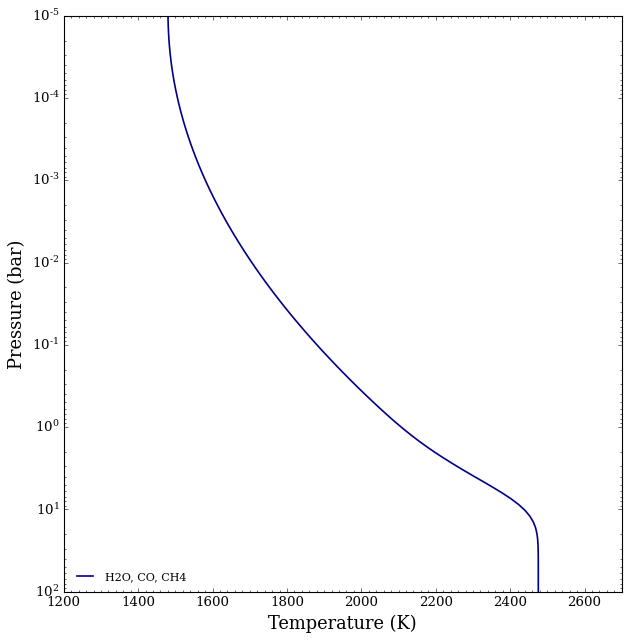

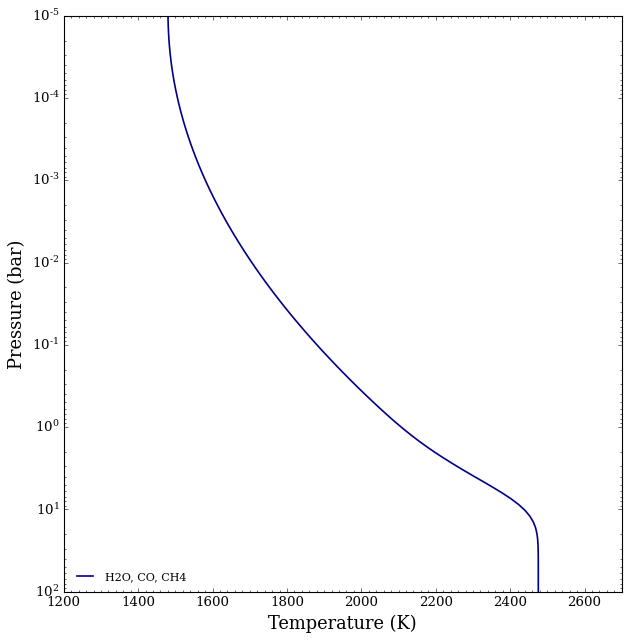

In [4]:
from POSEIDON.visuals import plot_PT

plot_PT(planet, model, atmosphere)

In [46]:
# data_dir = "./data/WASP-77Ab/"
# names = ["IGRINS"]
# data = read_high_res_data(data_dir, names)
import pickle

wl_grid, data_scale = pickle.load(
    open(
        "./data/WASP-77Ab/original_data/data_to_scale_with.pic",
        "rb",
    )
)

wl_grid, data_arr = pickle.load(
    open(
        "./data/WASP-77Ab/original_data/PCA_matrix.pic",
        "rb",
    )
)
phi = pickle.load(
    open(
        "./data/WASP-77Ab/original_data/phi.pic",
        "rb",
    )
)

data = {}
data["flux"] = data_arr + data_scale
data["wl_grid"] = wl_grid
data["residuals"] = data_arr
data["phi"] = phi
inject_dir = "./data/WASP-77Ab-injection/"
inject_name = "H2O_CO_pca"

make_injection_data(
    data,
    inject_dir,
    inject_name,
    wl,
    spectrum * 1.5,
    -200,
    -20,
    "pca",
    a=None,
    continuum=None,
    W_conv=1,
    star_spectrum=star["F_star"] * R_s**2,
)

Creating processed data at ./data/WASP-77Ab-injection/H2O_CO_pca/data_processed.hdf5


In [47]:
data = read_high_res_data(inject_dir, names=[inject_name])

In [48]:
from scipy.ndimage import gaussian_filter1d, maximum_filter1d, minimum_filter1d

Kp_range = np.arange(-300, 1, 1)
Vsys_range = np.arange(-100, 61, 1)
RV_range = np.arange(-400, 61, 1)

CCF_Kp_Vsys_all = []
CCF_phase_RV_all = []
for key in data.keys():
    data[key]["uncertainties"] = np.ones_like(data[key]["residuals"])
    CCF_Kp_Vsys, CCF_phase_RV = cross_correlate(
        Kp_range,
        Vsys_range,
        RV_range,
        wl,
        # gaussian_filter1d(
        #     spectrum - gaussian_filter1d(minimum_filter1d(spectrum, 400), 100), 1
        # ),
        spectrum,
        data[key],
    )
    CCF_Kp_Vsys_all.append(CCF_Kp_Vsys)
    CCF_phase_RV_all.append(CCF_phase_RV)
CCF_phase_RV_all = np.array(CCF_phase_RV_all)
CCF_Kp_Vsys_all = np.array(CCF_Kp_Vsys_all)

Cross correlation took 17.55104351043701 seconds


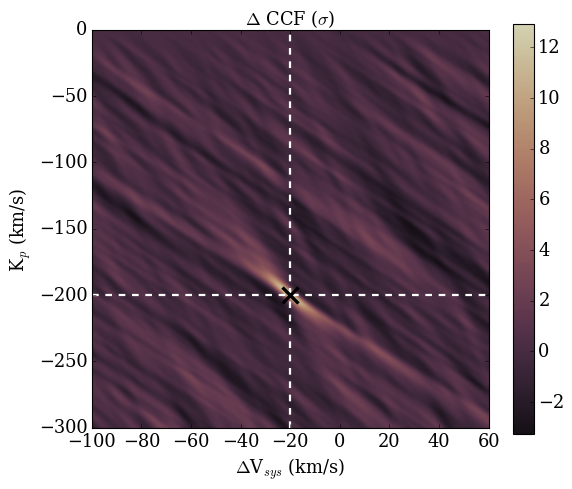

In [49]:
import matplotlib
import POSEIDON.visuals

if os.path.exists("./CC_output") == False:
    os.mkdir("./CC_output")

params = {
    "legend.fontsize": 14,
    "axes.labelsize": 16,
    "font.size": 16,
    "axes.titlesize": 16,
}
matplotlib.rcParams.update(params)
plot_CCF_Kp_Vsys(
    Kp_range,
    Vsys_range,
    np.sum(CCF_Kp_Vsys_all[:], axis=0),
    "All",
    -200,
    Vsys=-20,
    RM_mask_size=50,
    plot_label=False,
    cmap=cmr.get_sub_cmap("cmr.sepia", 0.1, 0.9),
    file_path="./CC_output/WASP77_injection_CCF.pdf",
    savefig=True,
)

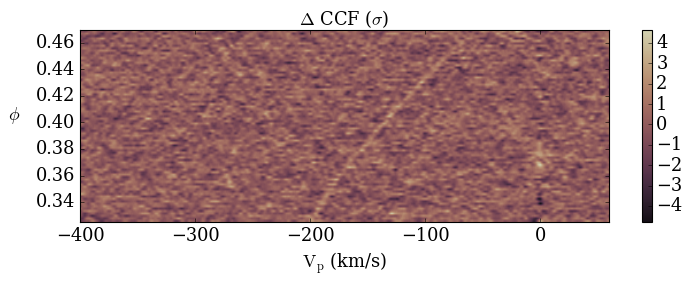

In [50]:
phi = data["H2O_CO_pca"]["phi"]
plot_CCF_phase_RV(
    phi,
    RV_range,
    np.mean(CCF_phase_RV_all, axis=0),
    "Fe",
    plot_label=False,
    save_path="./CC_output/WASP77_injection_CCF_phase.pdf",
    cmap=cmr.get_sub_cmap("cmr.sepia", 0.1, 0.9),
)